# Create a dataset using alpha vantage

In [109]:
try:
    import alpha_vantage
except:
    ! pip install alpha_vantage
    import alpha_vantage

import requests
from pprint import pprint
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import json
import time
from tqdm import tqdm
import os
sns.set()
pd.set_option('display.max_colwidth',1000)

## get all tickers from alpha vantange api

In [83]:
def get_symbols(start_date=0, end_date=0):
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: API_KEY
    # API KEY: 9XZQZQZQZQZQZQZQ
    # API KEY: demo
    CSV_URL = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=demo'
    return pd.read_csv(CSV_URL)

tickers = get_symbols()

### Do some pre-processing on the dataset to make it a bit more presentable

In [84]:
# set the index of the dataframe to the ticker symbol
tickers.set_index('symbol', inplace=True)
# sort the dataframe according to the date
tickers.sort_values('ipoDate', inplace=True)
# remove lines where delistingDate is not null
tickers = tickers[tickers['delistingDate'].isnull() & tickers['status'].str.contains('Active')]
# remove the delistingDate column
tickers.drop('delistingDate', axis=1, inplace=True)
# remove the status column
tickers.drop('status', axis=1, inplace=True)
# find any duplicates in the name column and remove the earliest ones from the dataframe
tickers.drop_duplicates(subset='name', keep='last', inplace=True)
# convert ipoDate to datetime and parse out the year of the IPO from the ipoDate column
tickers['ipoDate'] = pd.to_datetime(tickers['ipoDate'])
tickers['ipoYear'] = tickers['ipoDate'].dt.year
print(tickers.describe())
tickers

            ipoYear
count  11115.000000
mean    2012.311381
std       11.018321
min     1962.000000
25%     2006.000000
50%     2017.000000
75%     2021.000000
max     2023.000000


,name,exchange,assetType,ipoDate,ipoYear
symbol,,,,,
GE,General Electric Company,NYSE,Stock,1962-01-02,1962
CAT,Caterpillar Inc,NYSE,Stock,1962-01-02,1962
KO,Coca-Cola Company,NYSE,Stock,1962-01-02,1962
BA,Boeing Company,NYSE,Stock,1962-01-02,1962
IBM,International Business Machines Corp,NYSE,Stock,1962-01-02,1962
...,...,...,...,...,...
CVMC,Calvert US Mid-Cap Core Responsible Index ETF,NYSE ARCA,ETF,2023-02-01,2023
PBT,Permian Basin Royalty Trust,NYSE,Stock,2023-02-01,2023
ZSPY,ASYMmetric Smart Alpha S&P 500 ETF,NYSE ARCA,ETF,2023-02-01,2023


In [85]:
# locate the row containing the symbol aapl
pprint(tickers.loc['AAPL'])

name                   Apple Inc
exchange                  NASDAQ
assetType                  Stock
ipoDate      1980-12-12 00:00:00
ipoYear                     1980
Name: AAPL, dtype: object


### Plot the histogram with the number of ipos in the x axis

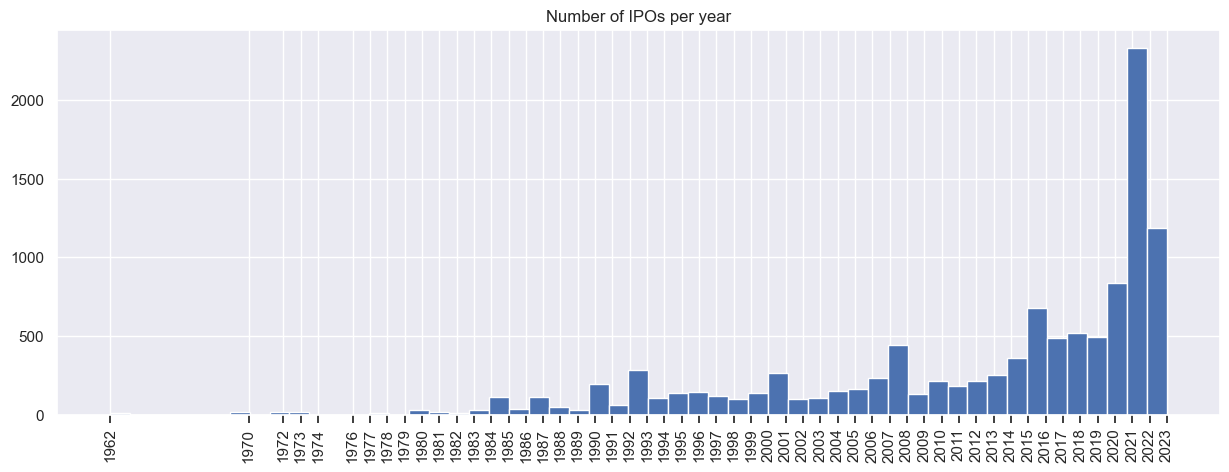

In [86]:
# get the number of unique values in the ipoYear column
years = tickers['ipoYear'].nunique()
# plot a histogram of the number of IPOs per year and show all the years on the x-axis
tickers['ipoYear'].hist(bins=years, xrot=90, figsize=(15, 5), align='mid')
plt.title('Number of IPOs per year')
plt.xticks(tickers['ipoYear'].unique())
# move all x ticks to the left
plt.gca().xaxis.tick_bottom()
plt.show()

In [87]:
# save the dataframe to a csv file
tickers.to_csv('tickers.csv')

## Build the news sentiments dataset

In [107]:
def get_sentiments(company_symbol: str = '', news_topic: str = '', time_from: str = '', time_to: str = ''):
    # Define the API endpoint and the parameters for the request
    # API KEY: NG88F4E3M06AUO7C
    # API KEY: API_KEY
    # API KEY: 9XZQZQZQZQZQZQZQ
    endpoint = "https://www.alphavantage.co/query"
    parameters = {
        "function": "NEWS_SENTIMENT",
        "sort": "RELEVANCE",
        "limit": "200",
        "apikey": "9XZQZQZQZQZQZQZQ",
    }
    if time_from and time_to: parameters['time_from'] = time_from; parameters['time_to'] = time_to
    if news_topic: parameters['topics'] = news_topic
    if company_symbol: parameters['tickers'] = company_symbol
    # Send a GET request to the API endpoint
    response = requests.get(endpoint, params=parameters)
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        try:
            data['note']
        except KeyError:
            return print('api overuse')
        # Parse the response JSON
        return response.json()
    else:
        # print the error message in the response
        print(response)

### Print news sentiments from the past week

In [115]:
# todo make this more concise
# create a dir called sentiments if it doesn't exist
if not os.path.exists('sentiments'): os.mkdir('sentiments')
# get the datetime of the past week in the format: YYYYMMDDTHHMM
start_time = datetime.now()
sentiment_list = []
# get the news up to 100 days ago. and every 5 iterations of action, sleep for one second
for i in tqdm(range(1, 101, 5)):
    for j in range(5):
        start_time -= timedelta(days=1)
        time_to = (start_time - timedelta(days=i+j)).strftime('%Y%m%dT%H%M')
        time_from = (start_time - timedelta(days=i+j+1)).strftime('%Y%m%dT%H%M')
        # get the news sentiment for the past week
        sentiment = get_sentiments(news_topic='financial_markets', time_from=time_from, time_to=time_to)
        if not sentiment: break
        # temporarily save the sentiments to a json file in a folder called sentiments
        with open(os.path.join('sentiments', f'sentiments{time_from}.json'), 'w') as f:
            json.dump(sentiment, f, indent=4)
        # append the sentiment to the list
        sentiment_list.append(sentiment)
    if not sentiment: break
    time.sleep(60)

  0%|          | 0/20 [00:00<?, ?it/s]

200